# VJEPA2 Model Analysis and Inference Demo

This notebook demonstrates how to use the utility functions to:
1. Load a trained VJEPA2 model
2. Analyze the model architecture
3. Run inference on video files
4. Visualize results

## Setup

In [1]:
# Import required libraries
import sys
import pathlib
import matplotlib.pyplot as plt
import torch

# Add src directory to path to import our utils
sys.path.append('../src')
from utils import (
    load_trained_model,
    print_model_info,
    visualize_model_architecture,
    run_inference,
    display_video_frames,
    display_predictions,
    analyze_video_with_model,
    get_best_device
)

# Set up matplotlib for inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

print("📚 Libraries imported successfully!")
print(f"🖥️  Available device: {get_best_device()}")

✅ torchcodec imported successfully
✅ transformers with VJEPA2 imported successfully
📚 Libraries imported successfully!
🖥️  Available device: mps


## Configuration

Set up paths to your trained model and test videos.

In [2]:
# Configuration
MODEL_PATH = "../model/vjepa2-vitl-fpc16-256-ssv2-uvf101"  # Path to your trained model
VIDEO_DIR = "../UCF101_subset"  # Directory containing test videos

# Check if model exists
model_path = pathlib.Path(MODEL_PATH)
if model_path.exists():
    print(f"✅ Model found at: {MODEL_PATH}")
else:
    print(f"❌ Model not found at: {MODEL_PATH}")
    print("Please train a model first using 'make train' or update the MODEL_PATH")

# Find some test videos
video_dir = pathlib.Path(VIDEO_DIR)
if video_dir.exists():
    test_videos = list(video_dir.rglob("*.avi"))[:5]  # Get first 5 videos
    print(f"\n📹 Found {len(test_videos)} test videos:")
    for i, video in enumerate(test_videos):
        print(f"  {i+1}. {video.name} ({video.parts[-3]})")
else:
    print(f"❌ Video directory not found: {VIDEO_DIR}")
    print("Please download the dataset first using 'make download-data'")
    test_videos = []

✅ Model found at: ../model/vjepa2-vitl-fpc16-256-ssv2-uvf101

📹 Found 5 test videos:
  1. v_BalanceBeam_g11_c02.avi (test)
  2. v_BalanceBeam_g11_c04.avi (test)
  3. v_BalanceBeam_g20_c01.avi (test)
  4. v_BalanceBeam_g20_c03.avi (test)
  5. v_BaseballPitch_g11_c02.avi (test)


## 1. Load the Trained Model

Load your trained VJEPA2 model and processor.

In [17]:
# Load the trained model
if model_path.exists():
    model, processor = load_trained_model(MODEL_PATH)
    print("\n🎉 Model loaded successfully!")
else:
    print("⚠️  Cannot load model - please train one first or check the path")
    model, processor = None, None

print(type(model))
print(f"Model is PyTorch module: {isinstance(model, torch.nn.Module)}")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model dtype: {next(model.parameters()).dtype}")

Loading model from: ../model/vjepa2-vitl-fpc16-256-ssv2-uvf101
Using device: mps
Model loaded successfully!

🎉 Model loaded successfully!
<class 'transformers.models.vjepa2.modeling_vjepa2.VJEPA2ForVideoClassification'>
Model is PyTorch module: True
Model device: mps:0
Model dtype: torch.float32


## 2. Analyze Model Architecture

Let's examine the model's architecture and configuration.

In [4]:
if model is not None:
    # Print detailed model information
    print_model_info(model)
else:
    print("⚠️  Model not loaded - skipping architecture analysis")

MODEL INFORMATION
Model Type: VJEPA2ForVideoClassification
Model Config: vjepa2
Architecture: ['VJEPA2ForVideoClassification']

Model Dimensions:
  - Hidden Size: 1024
  - Number of Attention Heads: 16
  - Number of Hidden Layers: 24

Video Processing:
  - Image Size: 256
  - Patch Size: 16
  - Frames per Clip: 16
  - Tubelet Size: 2

Classification:
  - Number of Labels: 10
  - Label Classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam']...

Parameters:
  - Total Parameters: 375,317,898
  - Trainable Parameters: 375,317,898
  - Frozen Parameters: 0


In [5]:
if model is not None:
    # Visualize model architecture
    visualize_model_architecture(model)
else:
    print("⚠️  Model not loaded - skipping architecture visualization")

MODEL ARCHITECTURE
VJEPA2ForVideoClassification(
  (vjepa2): VJEPA2Model(
    (encoder): VJEPA2Encoder(
      (embeddings): VJEPA2Embeddings(
        (patch_embeddings): VJEPA2PatchEmbeddings3D(
          (proj): Conv3d(3, 1024, kernel_size=(2, 16, 16), stride=(2, 16, 16))
        )
      )
      (layer): ModuleList(
        (0-23): 24 x VJEPA2Layer(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attention): VJEPA2RopeAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): VJEPA2MLP(
            (fc1): Linear(i

## 3. Run Inference on Test Videos

Now let's run inference on some test videos and visualize the results.

In [6]:
# Select a test video for inference
if test_videos and model is not None:
    test_video = test_videos[0]  # Use the first video
    print(f"🎬 Analyzing video: {test_video.name}")
    print(f"📁 Category: {test_video.parts[-3]}")
    print(f"📍 Full path: {test_video}")
else:
    print("⚠️  No test videos available or model not loaded")
    test_video = None

🎬 Analyzing video: v_BalanceBeam_g11_c02.avi
📁 Category: test
📍 Full path: ../UCF101_subset/test/BalanceBeam/v_BalanceBeam_g11_c02.avi


In [7]:
# Run inference and get predictions
if test_video and model is not None:
    predicted_labels, confidence_scores, video_tensor = run_inference(
        model, processor, str(test_video), top_k=5
    )
    
    print("\n🎯 PREDICTION RESULTS:")
    print("=" * 40)
    for i, (label, score) in enumerate(zip(predicted_labels, confidence_scores)):
        print(f"{i+1}. {label}: {score:.3f} ({score*100:.1f}%)")
else:
    print("⚠️  Skipping inference - no video or model available")
    predicted_labels, confidence_scores, video_tensor = None, None, None

Running inference on: ../UCF101_subset/test/BalanceBeam/v_BalanceBeam_g11_c02.avi

🎯 PREDICTION RESULTS:
1. BalanceBeam: 0.794 (79.4%)
2. BaseballPitch: 0.045 (4.5%)
3. Basketball: 0.034 (3.4%)
4. Archery: 0.034 (3.4%)
5. BandMarching: 0.029 (2.9%)


## 4. Visualize Video Frames

Display the frames that were processed by the model.

📺 Displaying video frames processed by the model:


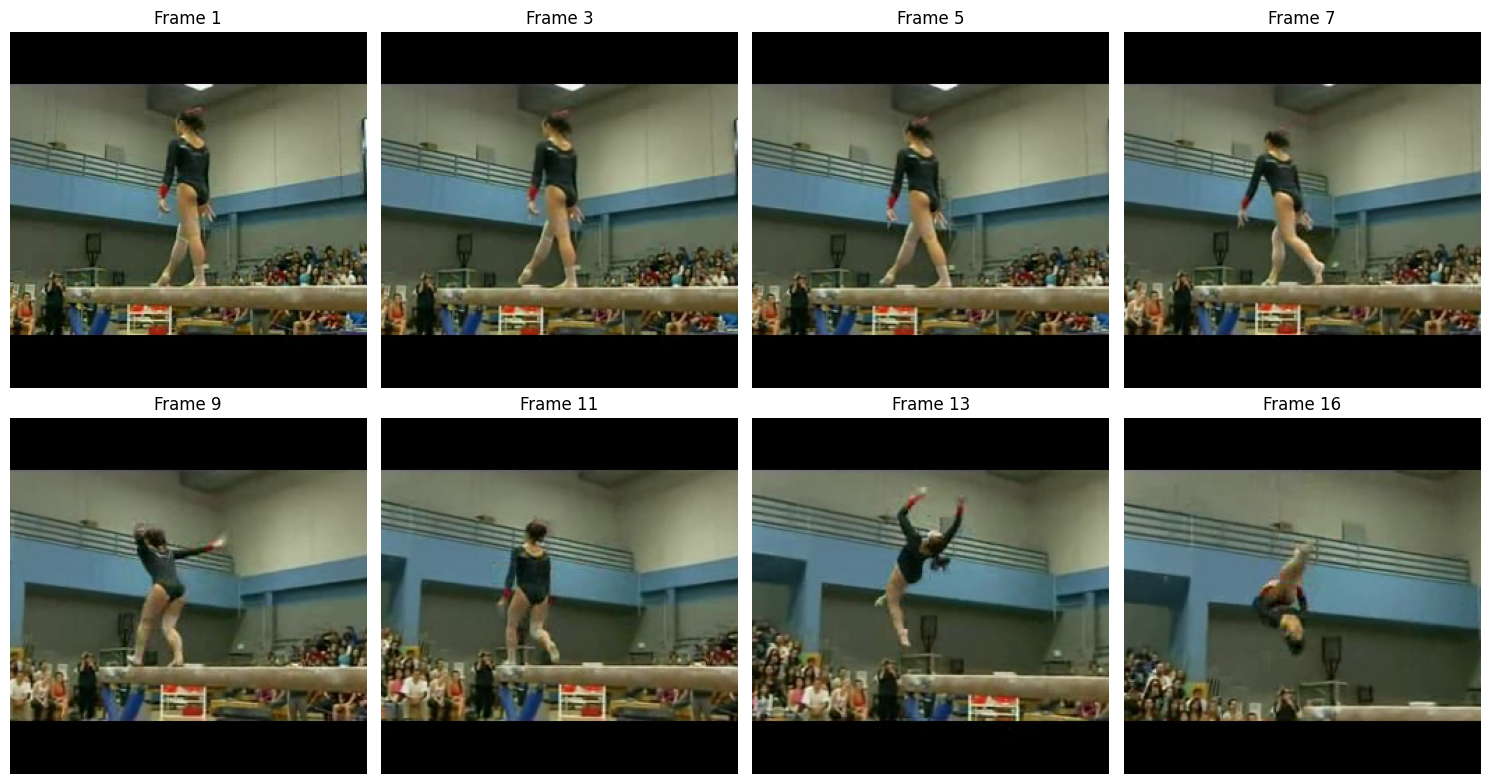

In [8]:
if video_tensor is not None:
    print("📺 Displaying video frames processed by the model:")
    display_video_frames(video_tensor, num_frames=8)
else:
    print("⚠️  No video tensor available for visualization")

## 5. Visualize Predictions

Create a bar chart showing the model's confidence for each predicted class.

📊 Prediction confidence visualization:


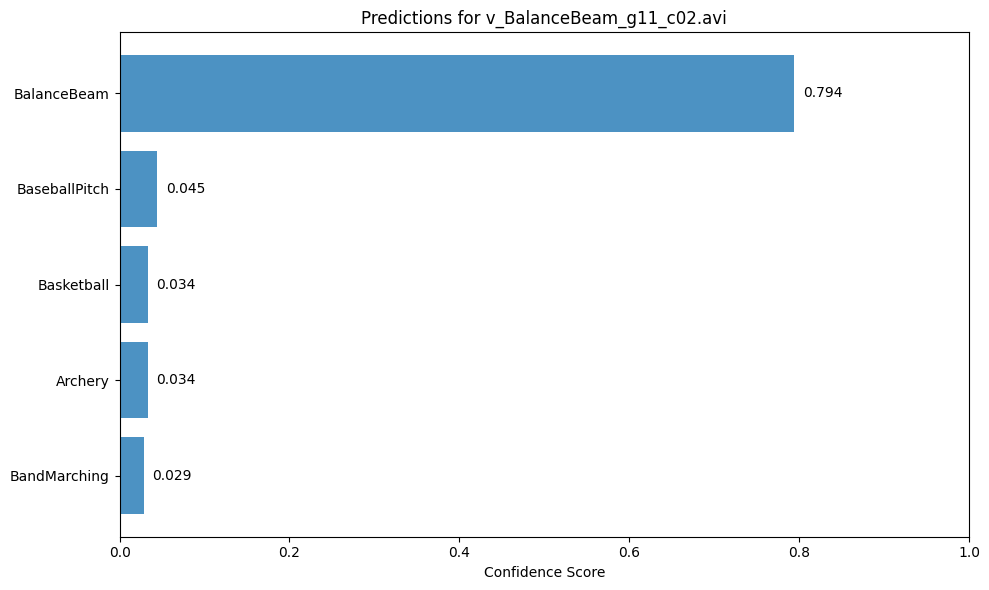

In [9]:
if predicted_labels and confidence_scores:
    print("📊 Prediction confidence visualization:")
    display_predictions(
        predicted_labels, 
        confidence_scores, 
        title=f"Predictions for {test_video.name if test_video else 'Test Video'}"
    )
else:
    print("⚠️  No predictions available for visualization")

## 6. Complete Analysis Pipeline

Use the all-in-one function to analyze multiple videos quickly.

🔄 Running complete analysis pipeline on multiple videos...


VIDEO 1/3: v_BalanceBeam_g11_c02.avi
Category: test
🎬 VJEPA2 Video Analysis Pipeline
Loading model from: ../model/vjepa2-vitl-fpc16-256-ssv2-uvf101
Using device: mps
Model loaded successfully!
MODEL INFORMATION
Model Type: VJEPA2ForVideoClassification
Model Config: vjepa2
Architecture: ['VJEPA2ForVideoClassification']

Model Dimensions:
  - Hidden Size: 1024
  - Number of Attention Heads: 16
  - Number of Hidden Layers: 24

Video Processing:
  - Image Size: 256
  - Patch Size: 16
  - Frames per Clip: 16
  - Tubelet Size: 2

Classification:
  - Number of Labels: 10
  - Label Classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam']...

Parameters:
  - Total Parameters: 375,317,898
  - Trainable Parameters: 375,317,898
  - Frozen Parameters: 0
Running inference on: ../UCF101_subset/test/BalanceBeam/v_BalanceBeam_g11_c02.avi

🎯 PREDICTIONS FOR: v_BalanceBeam_g11_c02.avi
------------------------------

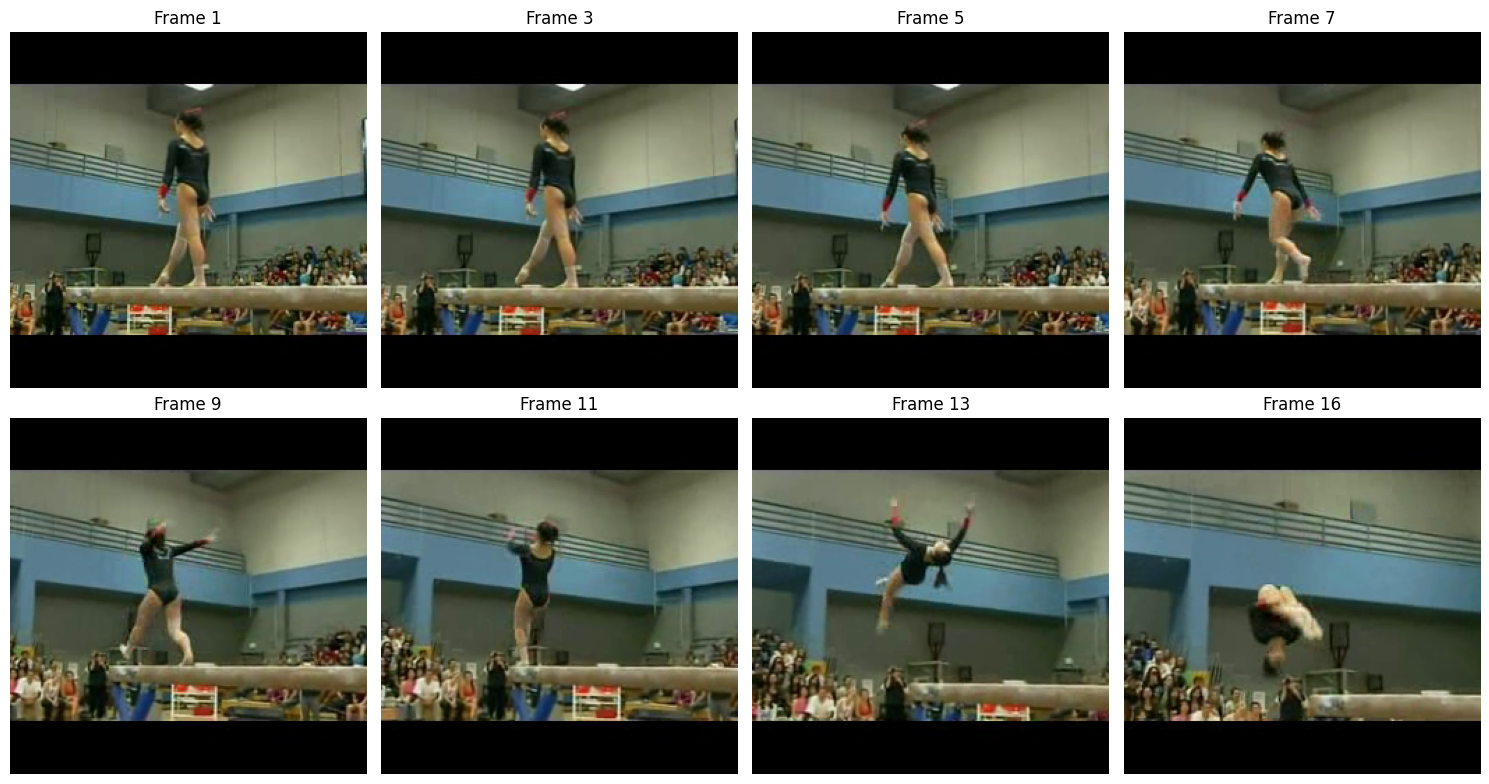


📊 Prediction Visualization:


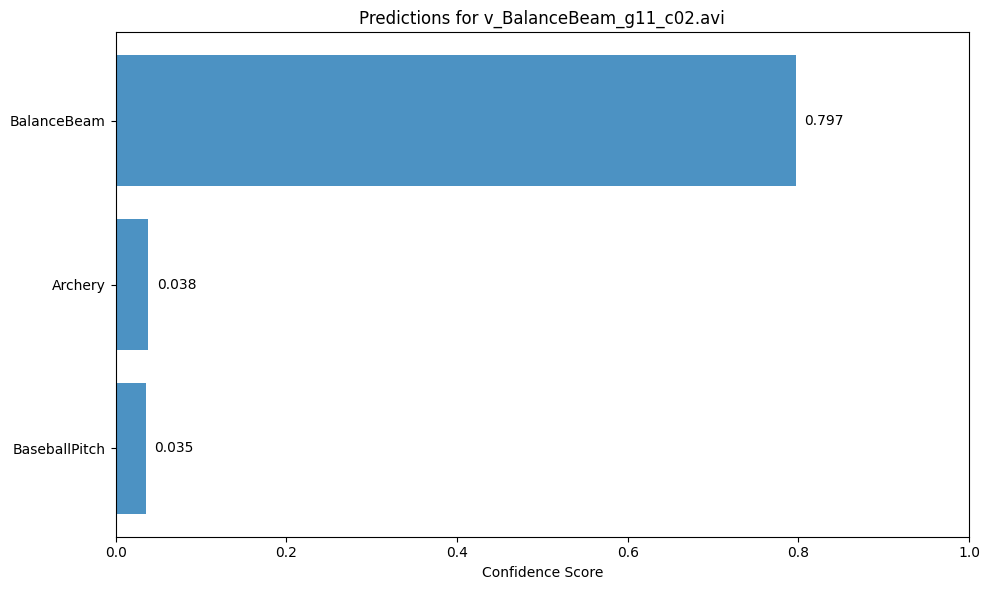




VIDEO 2/3: v_BalanceBeam_g11_c04.avi
Category: test
🎬 VJEPA2 Video Analysis Pipeline
Loading model from: ../model/vjepa2-vitl-fpc16-256-ssv2-uvf101
Using device: mps
Model loaded successfully!
MODEL INFORMATION
Model Type: VJEPA2ForVideoClassification
Model Config: vjepa2
Architecture: ['VJEPA2ForVideoClassification']

Model Dimensions:
  - Hidden Size: 1024
  - Number of Attention Heads: 16
  - Number of Hidden Layers: 24

Video Processing:
  - Image Size: 256
  - Patch Size: 16
  - Frames per Clip: 16
  - Tubelet Size: 2

Classification:
  - Number of Labels: 10
  - Label Classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam']...

Parameters:
  - Total Parameters: 375,317,898
  - Trainable Parameters: 375,317,898
  - Frozen Parameters: 0
Running inference on: ../UCF101_subset/test/BalanceBeam/v_BalanceBeam_g11_c04.avi

🎯 PREDICTIONS FOR: v_BalanceBeam_g11_c04.avi
----------------------------------------
1. BalanceBeam: 0.524 (52.4%)
2. Basketball: 0.

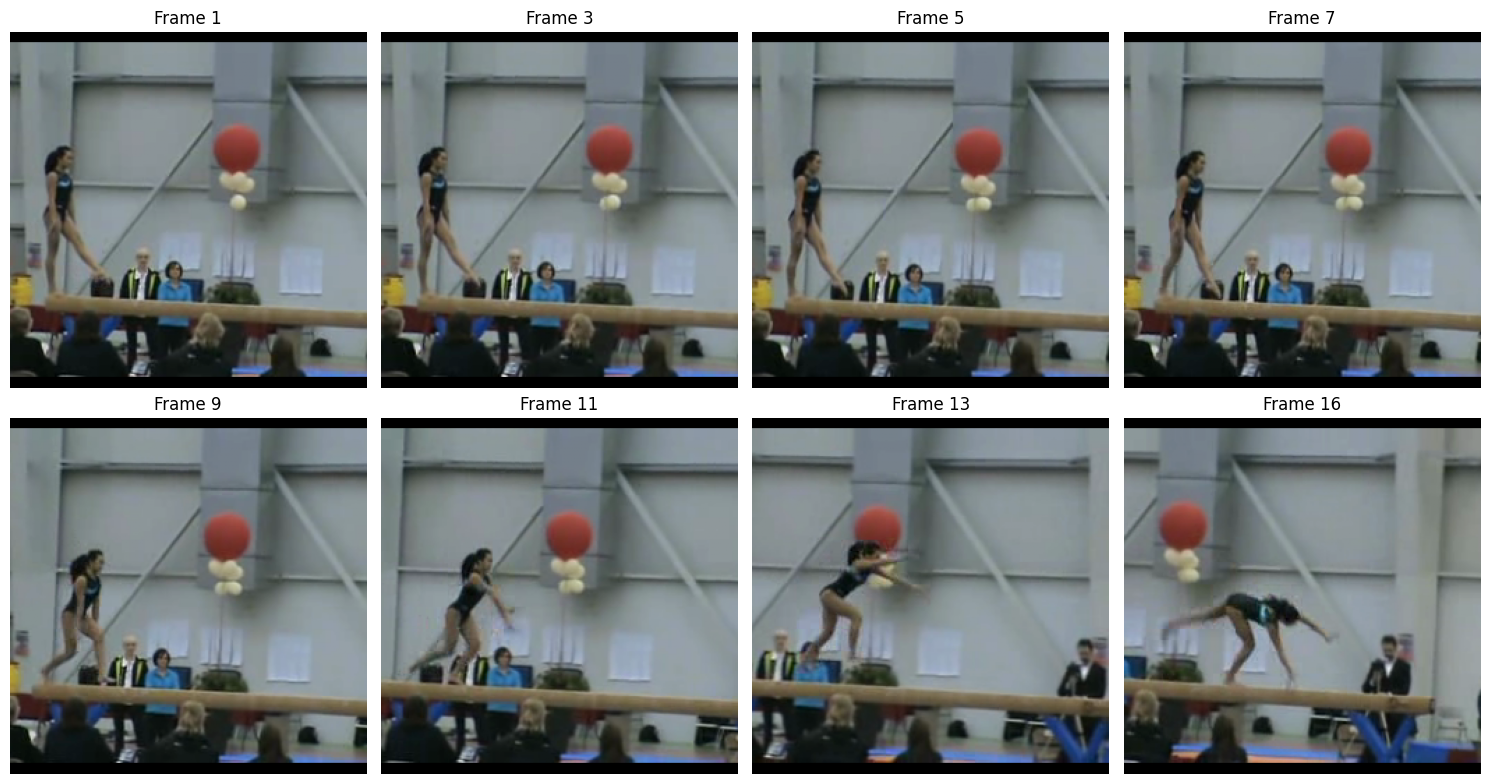


📊 Prediction Visualization:


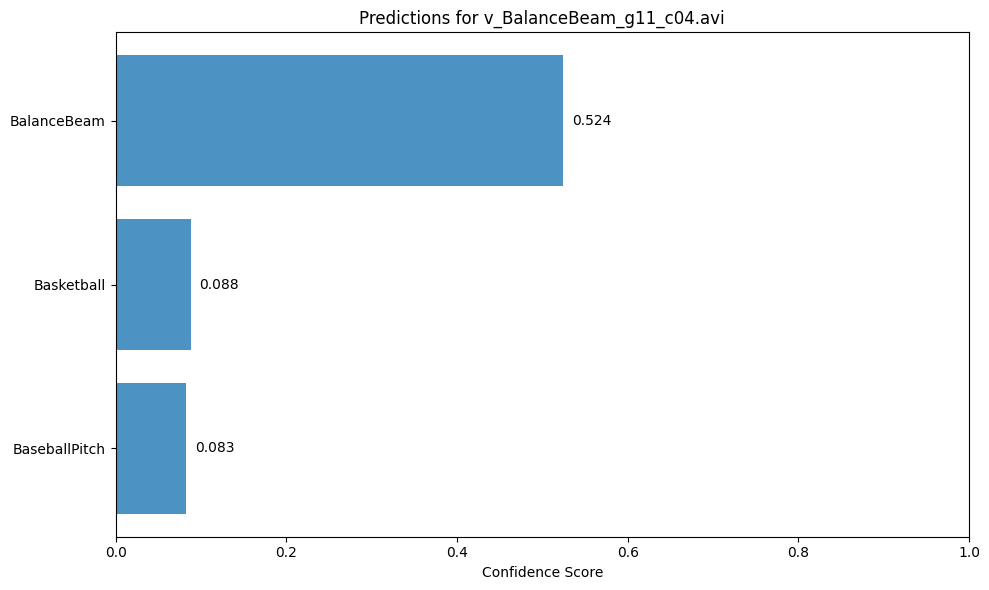




VIDEO 3/3: v_BalanceBeam_g20_c01.avi
Category: test
🎬 VJEPA2 Video Analysis Pipeline
Loading model from: ../model/vjepa2-vitl-fpc16-256-ssv2-uvf101
Using device: mps
Model loaded successfully!
MODEL INFORMATION
Model Type: VJEPA2ForVideoClassification
Model Config: vjepa2
Architecture: ['VJEPA2ForVideoClassification']

Model Dimensions:
  - Hidden Size: 1024
  - Number of Attention Heads: 16
  - Number of Hidden Layers: 24

Video Processing:
  - Image Size: 256
  - Patch Size: 16
  - Frames per Clip: 16
  - Tubelet Size: 2

Classification:
  - Number of Labels: 10
  - Label Classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam']...

Parameters:
  - Total Parameters: 375,317,898
  - Trainable Parameters: 375,317,898
  - Frozen Parameters: 0
Running inference on: ../UCF101_subset/test/BalanceBeam/v_BalanceBeam_g20_c01.avi

🎯 PREDICTIONS FOR: v_BalanceBeam_g20_c01.avi
----------------------------------------
1. BalanceBeam: 0.805 (80.5%)
2. Archery: 0.045

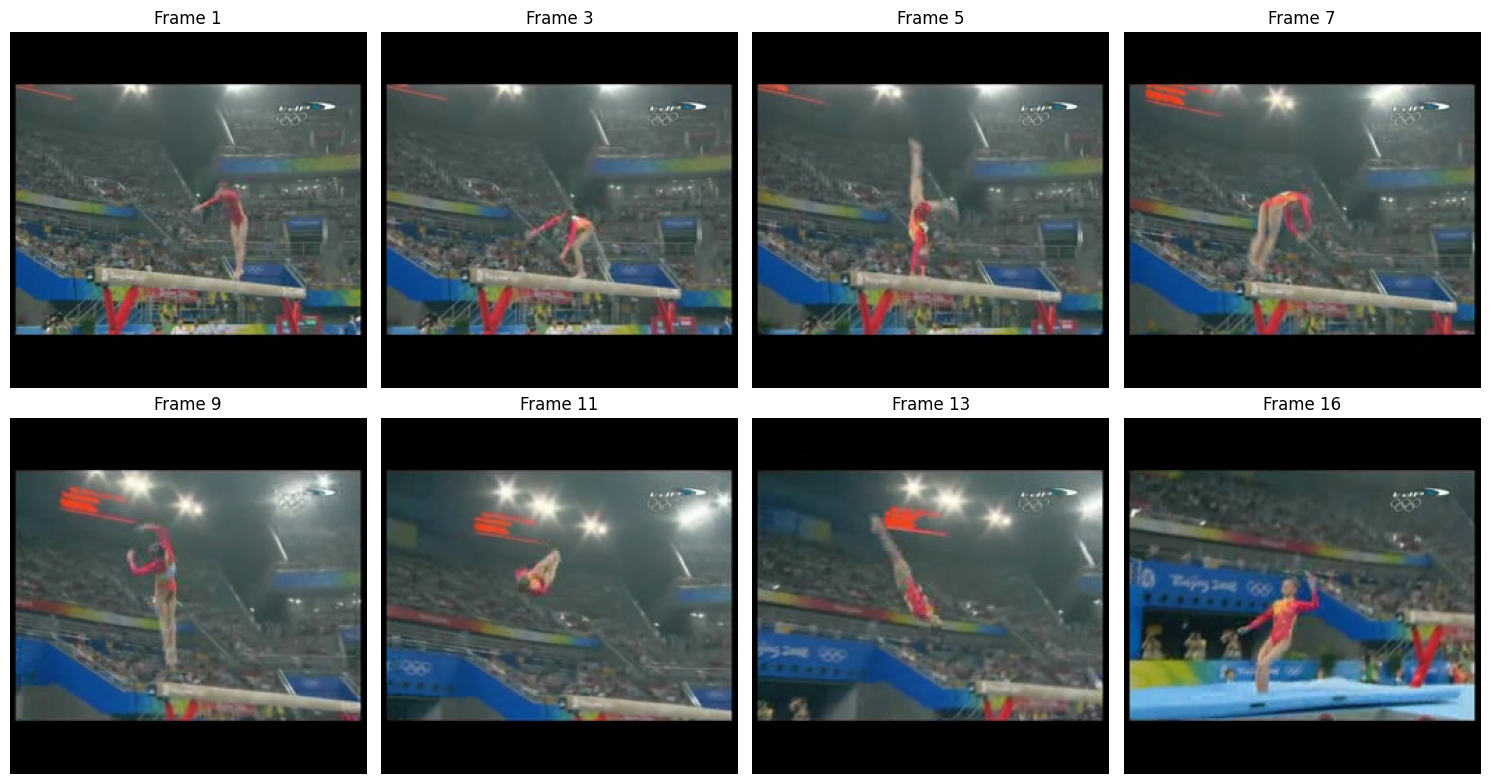


📊 Prediction Visualization:


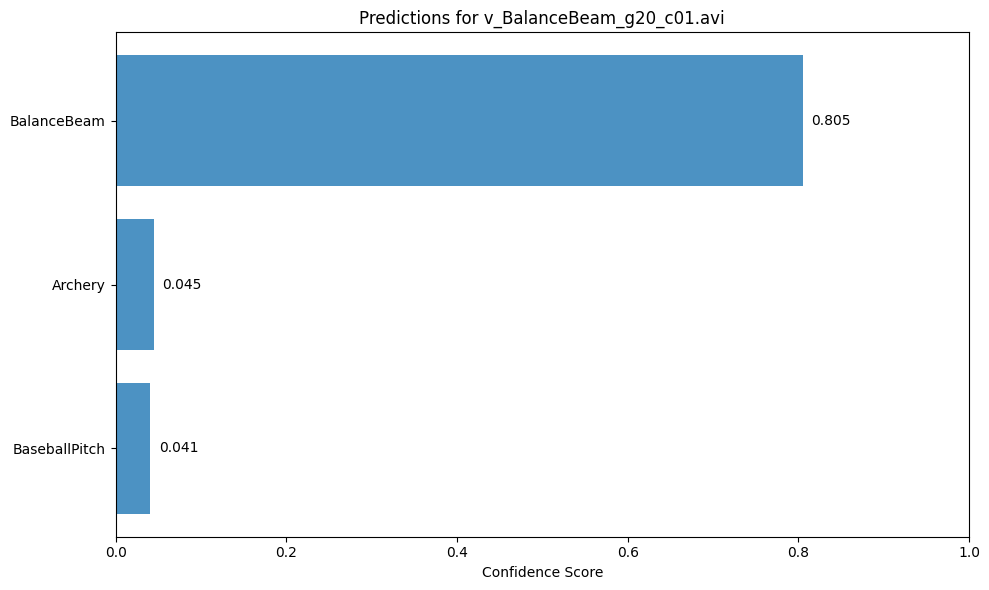

In [10]:
# Analyze multiple videos using the complete pipeline
if test_videos and model_path.exists():
    print("🔄 Running complete analysis pipeline on multiple videos...\n")
    
    # Analyze first 3 videos
    for i, video in enumerate(test_videos[:3]):
        print(f"\n{'='*60}")
        print(f"VIDEO {i+1}/3: {video.name}")
        print(f"Category: {video.parts[-3]}")
        print(f"{'='*60}")
        
        try:
            # Use the complete analysis function
            model_result, processor_result, labels, scores = analyze_video_with_model(
                MODEL_PATH, 
                str(video),
                display_frames=True,
                display_preds=True,
                top_k=3
            )
        except Exception as e:
            print(f"❌ Error analyzing {video.name}: {e}")
            continue
            
        print("\n" + "="*60 + "\n")
else:
    print("⚠️  Skipping pipeline demo - no videos or model available")

## 7. Model Performance Summary

Let's create a summary of the model's performance on our test videos.

In [14]:
# Performance summary
if test_videos and model is not None:
    print("📈 MODEL PERFORMANCE SUMMARY")
    print("=" * 50)
    
    correct_predictions = 0
    total_predictions = 0
    results = []
    
    for video in test_videos[:5]:  # Test on first 5 videos
        try:
            # Get ground truth from directory structure
            true_label = video.parts[-2]  # Category from directory name
            
            # Run inference
            pred_labels, pred_scores, _ = run_inference(
                model, processor, str(video), top_k=1
            )
            
            predicted_label = pred_labels[0]
            confidence = pred_scores[0]
            
            # Check if prediction matches (case-insensitive)
            is_correct = true_label.lower() in predicted_label.lower()
            if is_correct:
                correct_predictions += 1
            total_predictions += 1
            
            results.append({
                'video': video.name,
                'true_label': true_label,
                'predicted_label': predicted_label,
                'confidence': confidence,
                'correct': is_correct
            })
            
            status = "✅" if is_correct else "❌"
            print(f"{status} {video.name[:30]:<30} | True: {true_label:<15} | Pred: {predicted_label:<15} | Conf: {confidence:.3f}")
            
        except Exception as e:
            print(f"❌ Error processing {video.name}: {e}")
            continue
    
    if total_predictions > 0:
        accuracy = correct_predictions / total_predictions
        print(f"\n📊 SUMMARY:")
        print(f"   Correct Predictions: {correct_predictions}/{total_predictions}")
        print(f"   Accuracy: {accuracy:.2%}")
        print(f"   Average Confidence: {sum(r['confidence'] for r in results)/len(results):.3f}")
    
else:
    print("⚠️  Cannot generate performance summary - no videos or model available")

📈 MODEL PERFORMANCE SUMMARY
Running inference on: ../UCF101_subset/test/BalanceBeam/v_BalanceBeam_g11_c02.avi
✅ v_BalanceBeam_g11_c02.avi      | True: BalanceBeam     | Pred: BalanceBeam     | Conf: 0.832
Running inference on: ../UCF101_subset/test/BalanceBeam/v_BalanceBeam_g11_c04.avi
✅ v_BalanceBeam_g11_c04.avi      | True: BalanceBeam     | Pred: BalanceBeam     | Conf: 0.396
Running inference on: ../UCF101_subset/test/BalanceBeam/v_BalanceBeam_g20_c01.avi
✅ v_BalanceBeam_g20_c01.avi      | True: BalanceBeam     | Pred: BalanceBeam     | Conf: 0.763
Running inference on: ../UCF101_subset/test/BalanceBeam/v_BalanceBeam_g20_c03.avi
✅ v_BalanceBeam_g20_c03.avi      | True: BalanceBeam     | Pred: BalanceBeam     | Conf: 0.648
Running inference on: ../UCF101_subset/test/BaseballPitch/v_BaseballPitch_g11_c02.avi
✅ v_BaseballPitch_g11_c02.avi    | True: BaseballPitch   | Pred: BaseballPitch   | Conf: 0.645

📊 SUMMARY:
   Correct Predictions: 5/5
   Accuracy: 100.00%
   Average Confidence:

## 8. Interactive Video Analysis

Try analyzing your own video by specifying the path below.

In [15]:
# Interactive analysis - specify your own video path
CUSTOM_VIDEO_PATH = ""  # Add your video path here

if CUSTOM_VIDEO_PATH and pathlib.Path(CUSTOM_VIDEO_PATH).exists() and model is not None:
    print(f"🎬 Analyzing custom video: {CUSTOM_VIDEO_PATH}")
    
    try:
        analyze_video_with_model(
            MODEL_PATH,
            CUSTOM_VIDEO_PATH,
            display_frames=True,
            display_preds=True,
            top_k=5
        )
    except Exception as e:
        print(f"❌ Error analyzing custom video: {e}")
        
elif CUSTOM_VIDEO_PATH:
    print(f"❌ Custom video not found: {CUSTOM_VIDEO_PATH}")
else:
    print("💡 To analyze your own video, set CUSTOM_VIDEO_PATH to the path of your video file")

💡 To analyze your own video, set CUSTOM_VIDEO_PATH to the path of your video file


## Conclusion

This notebook demonstrated how to:

1. ✅ **Load a trained VJEPA2 model** using `load_trained_model()`
2. ✅ **Analyze model architecture** with `print_model_info()` and `visualize_model_architecture()`
3. ✅ **Run inference on videos** using `run_inference()`
4. ✅ **Visualize video frames** with `display_video_frames()`
5. ✅ **Display predictions** using `display_predictions()`
6. ✅ **Use the complete pipeline** with `analyze_video_with_model()`

### Next Steps:

- **Train your own model**: Run `make train` to train a model on the UCF101 dataset
- **Experiment with different videos**: Try the model on your own video files
- **Fine-tune parameters**: Adjust the training configuration for better performance
- **Extend the utils**: Add more visualization and analysis functions

### Utility Functions Available:

```python
from src.utils import (
    load_trained_model,           # Load model and processor
    print_model_info,             # Display model architecture info
    visualize_model_architecture, # Show architecture diagram
    run_inference,                # Run model inference on video
    display_video_frames,         # Show video frames
    display_predictions,          # Visualize predictions
    analyze_video_with_model,     # Complete analysis pipeline
    get_best_device               # Get optimal device (MPS/CUDA/CPU)
)
```

Happy analyzing! 🎬🤖